In [1]:
# !pip install yfinance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

### Download&Preprocess NASDAQ time series

In [2]:
data = yf.download("^IXIC", start="2012-01-01", end="2022-01-01")

[*********************100%***********************]  1 of 1 completed


In [3]:
plt.style.use('fivethirtyeight')

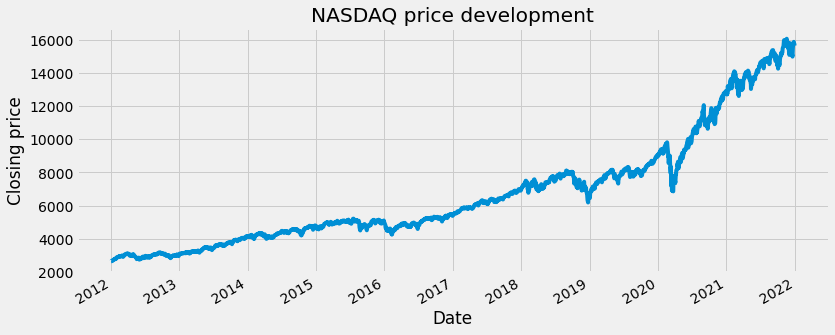

In [4]:
df = data['Adj Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

df.plot(ylabel='Closing price', title='NASDAQ price development',figsize=(12, 5))

In [5]:
# df.to_csv(f'./NASDAQ_daily.csv')

[Text(0, 0.5, 'relative return')]

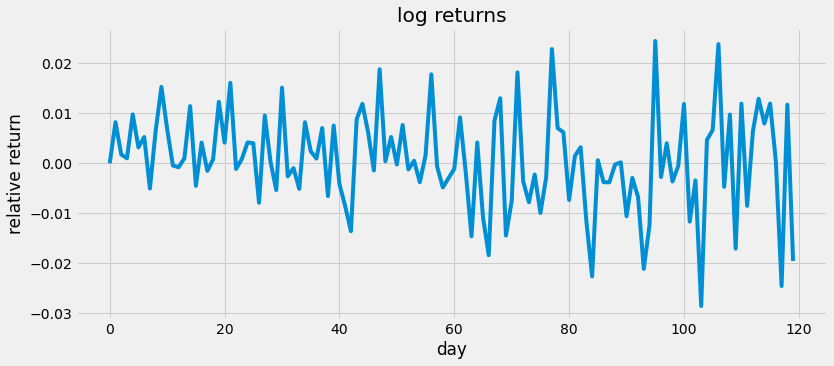

In [6]:
# log return 
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(log_returns[:120])
ax.set_title('log returns')
plt.setp(ax, xlabel='day')
plt.setp(ax, ylabel='relative return')

In [7]:
from preprocess.acf import *
from preprocess.gaussianize import *

In [8]:
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_done = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))

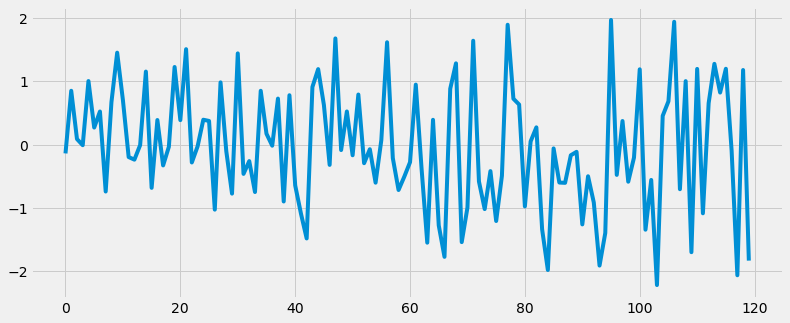

In [9]:
# gaussianized log return
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(log_returns_done[:120])

In [10]:
# test rolling window function
log_returns_rolled = rolling_window(log_returns_done, 127)

In [11]:
log_returns_rolled.shape

(127, 2390, 1)

(-4.0, 4.0)

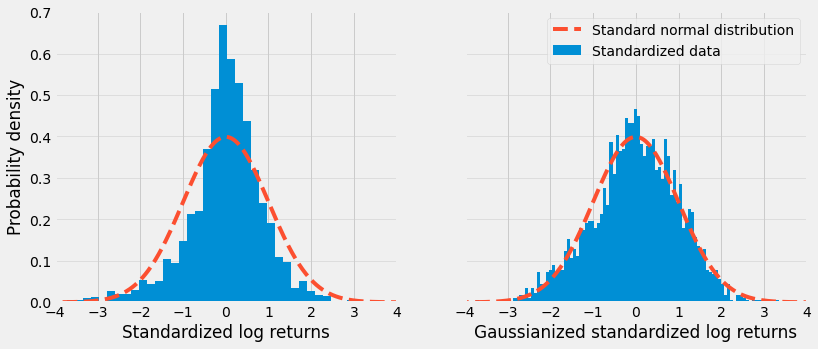

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True, sharex=True)
# Log returns before and after the lambert W inverse transform respectively (standardized)

ax[0].hist(standardScaler1.transform(log_returns), bins=100, density=True)
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range), linestyle='dashed')

ax[1].hist(log_returns_done, bins=100, density=True)
x_range = np.linspace(*ax[1].get_xlim(), num=1000)
ax[1].plot(x_range, norm.pdf(x_range), linestyle='dashed')

ax[0].yaxis.grid(True, alpha=0.5)
ax[1].yaxis.grid(True, alpha=0.5);

ax[1].legend(['Standard normal distribution', 'Standardized data'])
ax[0].set_ylabel('Probability density')
ax[0].set_xlabel('Standardized log returns')
ax[1].set_xlabel('Gaussianized standardized log returns')

ax[0].set_xlim(-4, 4)

### Model & Train

In [83]:
# build the model

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    """Creates a temporal block.
    Args:
        n_inputs (int): number of inputs.
        n_outputs (int): size of fully connected layers.
        kernel_size (int): kernel size along temporal axis of convolution layers within the temporal block.
        dilation (int): dilation of convolution layers along temporal axis within the temporal block.
        padding (int): padding
        dropout (float): dropout rate
    Returns:
        tuple of output layers
    """
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        if padding == 0:
            self.net = nn.Sequential(
                weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)),
                nn.ReLU(), 
                nn.Dropout(dropout), 
                weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)), 
                nn.ReLU(), 
                nn.Dropout(dropout))
        else:
            self.net = nn.Sequential(
                weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)), 
                Chomp1d(padding), 
                nn.ReLU(), 
                nn.Dropout(dropout), 
                weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)), 
                Chomp1d(padding), 
                nn.ReLU(), 
                nn.Dropout(dropout))

        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        return out, self.relu(out)



class Generator(nn.Module):
    # Causal temporal convolutional network with skip connections
    def __init__(self):
        super(Generator, self).__init__()
        self.tcn = nn.ModuleList([
            TemporalBlock(3, 80, kernel_size=1, stride=1, dilation=1, padding=0),
            TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=1, padding=1),
            TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=2, padding=2),
            TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=4, padding=4),
            TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=8, padding=8),
            TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=16, padding=16),
            TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=32, padding=32)])
        self.last = nn.Conv1d(80, 1, kernel_size=1, stride=1, dilation=1)

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return x


class Discriminator(nn.Module):
    # Causal temporal convolutional network with skip connections
    def __init__(self, seq_len, conv_dropout=0.05):
        super(Discriminator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(1, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=1, padding=1),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=2, padding=2),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=4, padding=4),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=8, padding=8),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=16, padding=16),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=32, padding=32)])
        self.last = nn.Conv1d(80, 1, kernel_size=1, dilation=1)
        self.to_prob = nn.Sequential(nn.Linear(127, 1), nn.Sigmoid())

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
#         print(x.shape)
        return self.to_prob(x).squeeze()

In [84]:
from torch.utils.data import Dataset, DataLoader

In [85]:
class Loader(Dataset):
# load by batch
    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)

In [86]:
# set parameters

num_epochs = 50
nz = 3
batch_size = 80
seq_len = 127
clip= 0.01
lr = 0.0002

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"

device = torch.device(dev) 

In [87]:
# some tests with the dimensions
generator = Generator().to(device)
discriminator = Discriminator(seq_len).to(device)

In [88]:
dataset = Loader(log_returns_done, 127)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
for data in dataloader:
    print(data.shape)
    break

torch.Size([80, 1, 127])


In [78]:
generator(torch.randn(80,3,127)).shape

torch.Size([80, 1, 127])

In [79]:
discriminator(torch.randn(80,1,127)).shape

torch.Size([80])

In [89]:
# this may fail when run the first time, run it again will successfully start training
import torch.optim as optim
from tqdm import tqdm

generator = Generator().to(device)
discriminator = Discriminator(seq_len).to(device)

disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)

dataset = Loader(log_returns_done, 127)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

t = tqdm(range(num_epochs))
for epoch in t:
    for idx, data in enumerate(dataloader, 0):

        discriminator.zero_grad()
        real = data.to(device)
        noise = torch.randn(batch_size, nz, seq_len, device=device)
        fake = generator(noise).detach()
#         print(noise.shape,fake.shape)
        disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
        disc_loss.backward()
        disc_optimizer.step()

        for dp in discriminator.parameters():
            dp.data.clamp_(-clip, clip)

        if idx % 5 == 0:
            generator.zero_grad()
            gen_loss = -torch.mean(discriminator(generator(noise)))
            gen_loss.backward()
            gen_optimizer.step()            
    t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))

Discriminator Loss: 0.00000122 Generator Loss: -0.49875832: 100%|██████████| 50/50 [23:12<00:00, 27.84s/it] 


### Result

In [90]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
y = generator(noise).cpu().detach().squeeze();

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

80

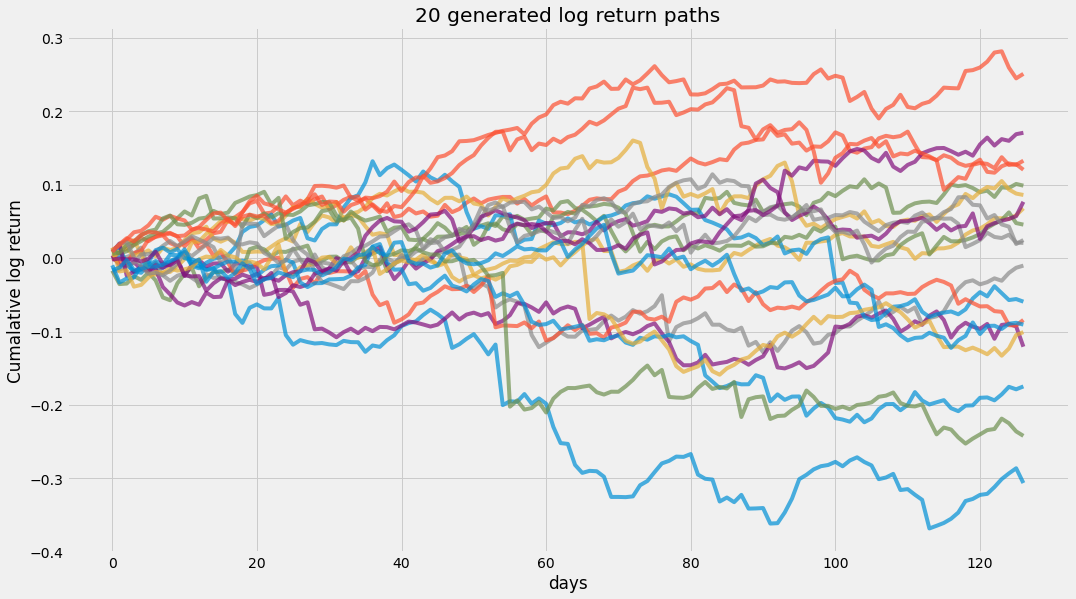

In [91]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:20], axis=1).T, alpha=0.7)
ax.set_title('20 generated log return paths')
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

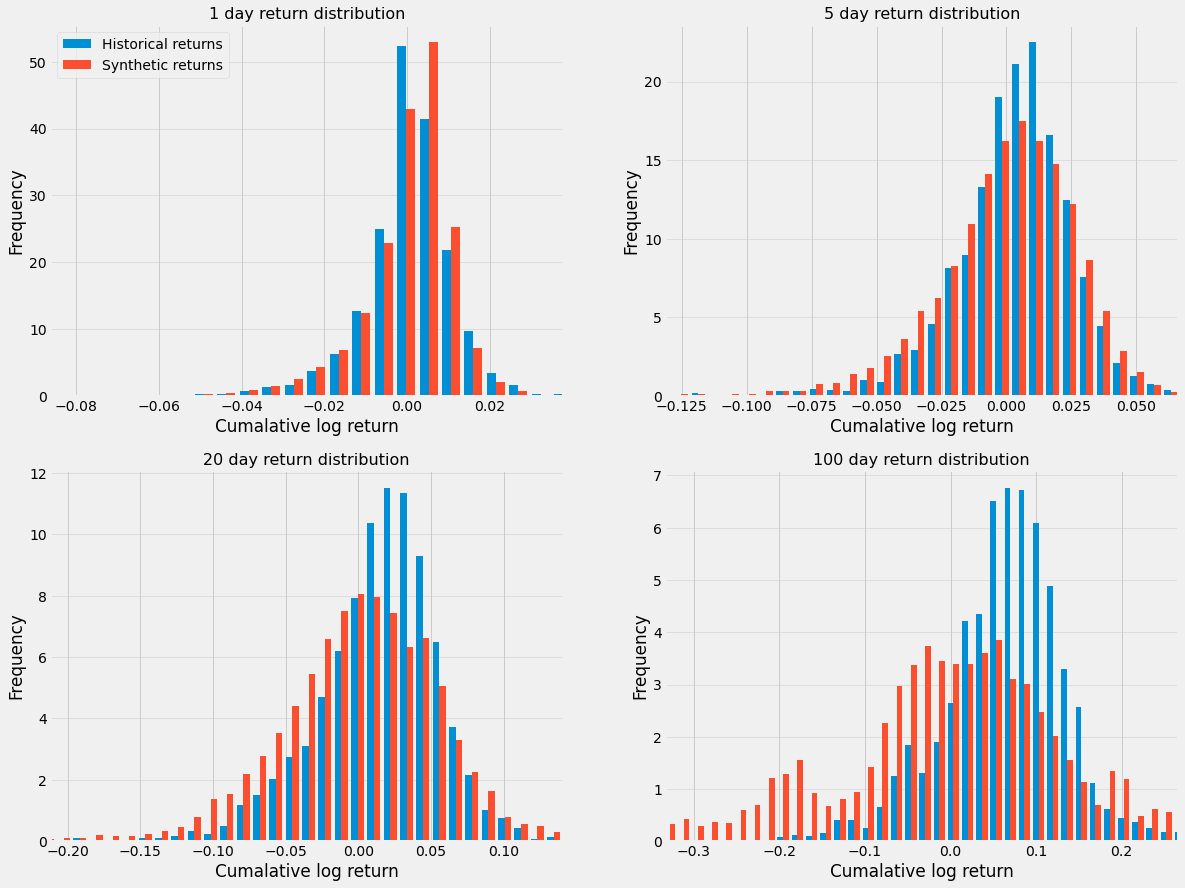

In [94]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])